In [1]:
#| warning: false

library(quanteda)
library(quanteda.textmodels)
library(quanteda.textplots)
library(quanteda.textstats)
library(quanteda.corpora)

library(LSX)

library(tidyverse)
library(ggpubr)
library(gridExtra)

old = theme_set(theme_bw(base_family="IPAPGothic"))
par(family="IPAGothic")

Package version: 4.3.1
Unicode version: 14.0
ICU version: 70.1

Parallel computing: disabled

See https://quanteda.io for tutorials and examples.

Registered S3 methods overwritten by 'LSX':
  method                       from               
  print.coefficients_textmodel quanteda.textmodels
  print.statistics_textmodel   quanteda.textmodels
  print.summary.textmodel      quanteda.textmodels


次のパッケージを付け加えます: ‘LSX’


以下のオブジェクトは ‘package:quanteda.textmodels’ からマスクされています:

    as.coefficients_textmodel, as.statistics_textmodel,
    as.summary.textmodel


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    m

In [2]:
#| echo: false

wordfish <- function(ys, remove_stopwords=TRUE, stem=TRUE, min_docfreq = 3, max_docfreq = 0.8) {
  corpus <- corpus(ys, text_field = 'body')
  
  toks <- corpus %>% 
    tokens(remove_punct = TRUE) %>% 
    tokens_tolower()

  if (stem) {
    tok <- toks %>% 
      tokens_wordstem()
  }
  
  if (remove_stopwords) {
    toks <- toks %>% 
      tokens_remove(stopwords('english'))  
  }

  mx <- toks %>% 
    dfm() %>% 
    dfm_trim(min_docfreq = min_docfreq, max_docfreq = as.integer(ndoc(corpus) * max_docfreq))
  
  wf <- textmodel_wordfish(mx, dir = c(2, 1))

  return(wf)
}

print_beta <- function(wf, topn = 10, reverse = FALSE) {
  print_word_coef(wf, name='beta', topn=topn, reverse=reverse)
}

print_psi <- function(wf, topn = 10, reverse = FALSE) {
  print_word_coef(wf, name='psi', topn=topn, reverse=reverse)
}

print_word_coef <- function(wf, name = 'beta', topn = 10, reverse = FALSE) {
  feat <- coef(wf)$features
  param <- feat[, ifelse(name == 'beta', 1, 2)]
  if (reverse) {
    tmp_param <- -param
  } else {
    tmp_param <- param
  }
  for (i in order(tmp_param)[1:topn]) {
    cat(paste(param[i], dimnames(feat)[[1]][i], '\n'))
  }
}

print_theta <- function(wf, corpus, name = 'theta', topn = 5, reverse = FALSE) {
  print_document_coef(wf, corpus, name=name, topn=topn, reverse=reverse)
}

print_document_coef <- function(wf, corpus, name = 'theta', topn = 5, reverse = FALSE) {
  feat <- coef(wf)$documents
  param <- feat[, ifelse(name == 'theta', 1, 2)]
  if (reverse) {
    tmp_param <- -param
  } else {
    tmp_param <- param
  }
  for (i in order(tmp_param)[1:topn]) {
    cat(paste(param[i], '\n'))
    cat(paste(as.character(corpus[i]), '\n\n'))
  }
}

## これまでの手法
政治学、社会学の分野で広く使われているものとして Wordfish (2008) と LSS (2020) がある。

### Wordfish
A Scaling Model for Estimating Time-Series Party Positions from Texts  
<http://www.wordfish.org/uploads/1/2/9/8/12985397/slapin_proksch_ajps_2008.pdf>

Wordfishはテキストの系列から極性の変化を発見することのできる教師なし学習の統計モデルであり、ポアソン分布に基づいた生成モデルになっている。

$y_{ivt}$ を政党$i$が時刻$t$のテキスト(たとえば選挙時の公約)で単語$v$を使った頻度とすると、観測値$Y=\{y_{ivt}\}_{i,v,t}$について, Wordfishは次の確率を最大化するパラメータ$(\alpha, \phi, \beta, \theta)$を求める。

$$
\left\{
\begin{align}
p(Y) &= \prod_i\prod_t\prod_v Po (y_{ivt}|\lambda_{ivt}) \\
\lambda_{ivt} &= \exp(\alpha_{it} + \phi_{v} + \beta_{v} \cdot \theta_{it})
\end{align}
\right.
$$
$\alpha_{it}$は、テキスト$it$ での固定効果、$\beta_{v}$は、単語$v$の固定効果。  
興味があるのは、単語$v$の極性軸上での位置$\beta_v$と政党$i$の時刻$t$での潜在位置$\theta_{it}$となる。

これは、単語頻度$y_{ivt}$の期待値は、テキスト$it$と単語$v$で決まるベースライン$\alpha_{it} + \phi_{v}$を、政党の持つ極性$\theta_{it}$と単語の持つ極性$\beta_{v}$で上下して決まるという事を表している。

$\theta$と$\beta$の極性が同じとき、例えば  
$\theta_{it}>0$が右翼を表す場合は、単語$v$(たとえば軍備)の位置も同様に$\beta_v>0$  
$\theta_{it}<0$が左翼を表す場合は、単語$v$(たとえば社会保障)の位置も同様に$\beta_v<0$  
の時に期待値は増加し、$\theta$と$\beta$の極性が異なる時に期待値は減少するモデルになっている。

パラメータ$(\alpha, \phi, \beta, \theta)$の推定は、EMアルゴリズム（最尤法）で行う。  

### LSS (Latent Semantic Scaling)
Latent Semantic Scaling: A SemisupervisedText Analysis Technique for New Domains andLanguages  
<https://www.tandfonline.com/doi/full/10.1080/19312458.2020.1832976>

LSS は、分析対象となるテキストを選択するために目標語 (target words) を、尺度の視点を与えるために種語 (seed words) を指定することのできる半教師ありの手法となる。

LSS ではまず指定した目標語を使って分析に用いる語彙を特徴語 (entry words) として決定する。これには目標語 (たとえば "econom*" や "政治")から一定の窓内で共起した語のうち、符号付き χ2 検定値の小さい順にたとえば 2,000 語を用い、"growth,social, recovery,···"のような語彙を特徴語とする。  
さらに、潜在意味解析 (LSA) で求めた各特徴語の単語ベクトルを得る。

次に、尺度（極性軸）の視点として種語を指定する。その種語 $s$ の LSA による単語ベクトル $\vec{f}$ と各特徴語 $f$ の単語ベクトル $\vec{s}$ とのコサイン距離を使って各特徴語の極性値 $p[f]$ を下記のように計算する。

$$
\begin{align}
p[f] = \frac{1}{|S|}\sum_{s\in S}cos(\vec{f}, \vec{s})p[s]
\end{align}
$$

最後にテキストの極性は、テキストの含まれる特徴語 $d$ の極性値の平均値として計算される。$n(f)$ は特徴語 $f$ の $d$ 内での頻度、$|d|$ は $d$ の長さ。
$$
\begin{align}
p[d] = \frac{1}{|d|}\sum_{f\in d}n(f)p[f]
\end{align}
$$

## 分析例

### Wordfish による分析例

#### 例1. 2010年のアイルランドの予算演説

In [3]:
#| warning: false

toks <- data_corpus_irishbudget2010 %>% 
  tokens(remove_punct = TRUE)

mx <- toks %>% 
  dfm()

wf <- mx %>% 
  textmodel_wordfish(dir = c(6, 5))

smr_irish <- summary(wf)

##### 文書の極性軸上での推定位置 $\theta$

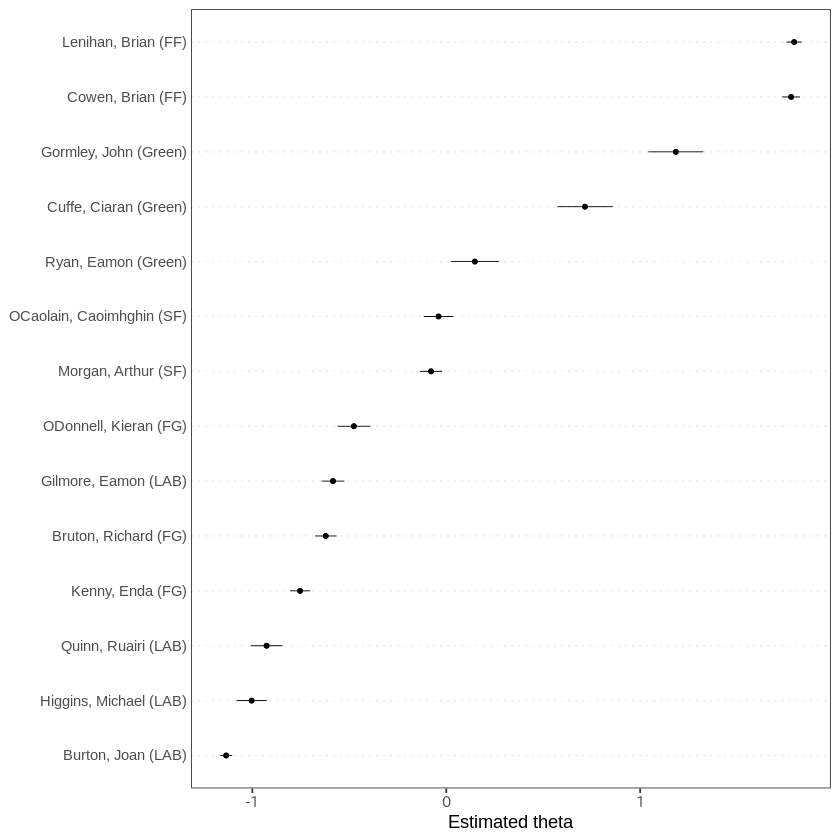

In [4]:
textplot_scale1d(wf, groups = wf$party)

##### 単語の極性軸上の推定位置 $\phi$ と $\beta$
単語に関するパラメータの推定値について、  
$\phi$ は、無極性単語、いわゆるストップワードや背景語（文脈固有のストップワード的なもの）に対して強い値がでることが期待される。  
逆に $\beta$ は、なんらかの極性軸上の極性語に対して強い値が出ることが期待される。

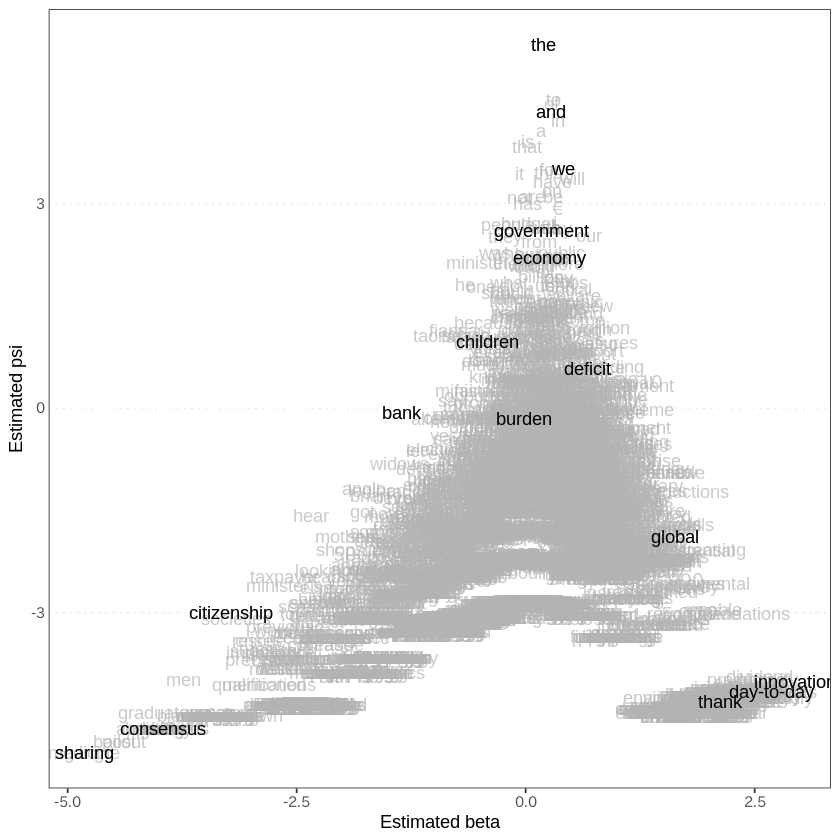

In [5]:
textplot_scale1d(wf, margin = "features", 
                 highlighted = c("innovation", "day-to-day", "thank",
                                 "sharing", "consensus",
                                 "the", "and", "we",
                                 "government", "global", "children", 
                                 "bank", "economy", "citizenship",
                                 "deficit", "burden"))

##### ストップワードや背景語（$\psi$ 上位）

In [6]:
print_psi(wf, topn=10, reverse = TRUE)

5.33077612037296 the 
4.51895963991204 to 
4.4655629835409 of 
4.3429945025913 and 
4.22245885386454 in 
4.06585936905273 a 
3.91458532139571 is 
3.83785434621164 that 
3.51245027118319 we 
3.49203474148904 for 


##### 正の極性語 ($\beta$ 上位) とその用例

In [7]:
print_beta(wf, topn=10, reverse=TRUE)

2.94378023795171 innovation 
2.72487301217451 stabilise 
2.71643848403018 shortly 
2.68683054430814 day-to-day 
2.60931123398265 summary 
2.57979744655352 sought 
2.57979744655352 arrangements 
2.57920625928674 phase 
2.55468122263866 dividend 
2.55144023679337 innovative 


In [8]:
kwic(toks, pattern = "innovation", valuetype = "glob", window = 5)
kwic(toks, pattern = "stabilise", valuetype = "glob", window = 5)

docname,from,to,pre,keyword,post,pattern
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
"Lenihan, Brian (FF)",2278,2278,on carbon This will encourage,innovation,by incentivising companies to bring,innovation
"Lenihan, Brian (FF)",5075,5075,will include science technology and,innovation,promotion of environmental sustainability implementation,innovation
"Lenihan, Brian (FF)",5598,5598,investment in research science and,innovation,Details of the new arrangements,innovation
"Lenihan, Brian (FF)",7175,7175,receiving the report of the,innovation,task force and I will,innovation
"Lenihan, Brian (FF)",7315,7315,is a growing area of,innovation,with huge commercial and employment,innovation
"Cowen, Brian (FF)",2734,2734,will be science technology and,innovation,the promotion of environmental sustainability,innovation
"Cowen, Brian (FF)",3350,3350,that Ireland will become an,innovation,hub a country that is,innovation
"Cowen, Brian (FF)",3419,3419,strategy for science technology and,innovation,to maximise the efficiency and,innovation
"Cowen, Brian (FF)",3579,3579,receiving the report of the,innovation,taskforce on its recommendations in,innovation


docname,from,to,pre,keyword,post,pattern
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
"Lenihan, Brian (FF)",421,421,now in a position to,stabilise,the deficit A total of,stabilise
"Lenihan, Brian (FF)",525,525,the Government's plan we must,stabilise,the deficit in a fair,stabilise
"Lenihan, Brian (FF)",883,883,range of far-reaching measures to,stabilise,the banking system We took,stabilise
"Lenihan, Brian (FF)",7827,7827,tax receipts have begun to,stabilise,consumer confidence is beginning to,stabilise
"Cowen, Brian (FF)",449,449,to stop We have to,stabilise,it we have to correct,stabilise
"Cowen, Brian (FF)",1002,1002,has three key objectives to,stabilise,the deficit in a fair,stabilise
"Cowen, Brian (FF)",5481,5481,fundamentally divided on how to,stabilise,the public finances This is,stabilise


##### $\beta$ 下位単語（負の極性語）とその用例

In [9]:
print_beta(wf, topn=10)

-4.81913104339958 sharing 
-4.81913104339958 medicine 
-4.81913104339958 gang 
-4.43546527785161 bailout 
-4.43546527785161 post 
-4.01114423617466 graduates 
-3.96347491647026 consensus 
-3.96347491647026 one's 
-3.96347491647026 apprentices 
-3.96347491647026 soft 


In [10]:
kwic(toks, pattern = "sharing", valuetype = "glob", window = 5)
kwic(toks, pattern = "medicine", valuetype = "glob", window = 5)

docname,from,to,pre,keyword,post,pattern
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
"Burton, Joan (LAB)",133,133,moment an opportunity for burden,sharing,by everyone but the Minister,sharing
"Burton, Joan (LAB)",156,156,of thought in which burden,sharing,like taxation is only for,sharing
"Burton, Joan (LAB)",267,267,is the fairness and burden,sharing,in the budget It is,sharing
"Burton, Joan (LAB)",640,640,As I stated the burden,sharing,introduced in the taxation measures,sharing
"Burton, Joan (LAB)",3414,3414,vision that can demand burden,sharing,on the understanding that it,sharing


docname,from,to,pre,keyword,post,pattern
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
"Burton, Joan (LAB)",3291,3291,in The economy certainly needs,medicine,The virus injected by successive,medicine
"Burton, Joan (LAB)",3309,3309,economic bloodstream has made painful,medicine,a necessity but the patient,medicine
"Burton, Joan (LAB)",3320,3320,needs nutrition as well as,medicine,to stage a full recovery,medicine
"Burton, Joan (LAB)",3331,3331,Today's budget is strong on,medicine,but sadly thin on nutrition,medicine
"Burton, Joan (LAB)",3656,3656,the professions in the law,medicine,and accountancy It means the,medicine


#### 例2. 2016年の大統領選挙に関する朝日新聞の記事

In [11]:
load('../data/data_corpus_asahi_2016.rda')

corpus <- corpus_trim(data_corpus_asahi_2016, exclude_pattern = "^(?!.*トランプ).*$")

toks <- corpus %>% 
  tokens(remove_punct = TRUE)

mx_trump <- toks %>% 
  dfm() %>% 
  dfm_remove(pattern = 'トランプ', valuetype = 'fixed') %>%
  dfm_remove(pattern = 'ドナルド', valuetype = 'fixed') %>%
  dfm_select(min_nchar = 2) %>% 
  dfm_remove('^[ぁ-ん]+$', valuetype = 'regex', min_nchar = 2) %>% 
  dfm_trim(min_docfreq = 3) %>% 
  dfm_subset(date >= '2016-01-01')

date <- seq(as.Date('2016-01-01'), as.Date('2016-12-31'), by = '1 day')

mx_trump <- mx_trump %>% 
  dfm_group(factor(docvars(mx_trump, 'date'), levels = as.factor(unique(date))), fill = FALSE)

mx_trump <- mx_trump[order(docnames(mx_trump)),]
mx_trump

wf_trump <- textmodel_wordfish(mx_trump)
result <- summary(wf_trump)

trump_theta = tibble(
  Date = as.Date(names(which(ntoken(mx_trump) > 0))),
  Estimated_theta = result$estimated.document.positions$theta
)

Document-feature matrix of: 259 documents, 2,296 features (96.22% sparse) and 3 docvars.
            features
docs         米国 共和 大統領 候補 選び イスラム教 入国 禁止 放言 続ける
  2016-01-01    1    2      2    1    1          2    1    1    1      1
  2016-01-04    0    0      1    0    0          0    0    0    0      0
  2016-01-10    0    1      1    1    0          1    1    1    0      0
  2016-01-11    0    1      1    1    0          1    1    1    0      0
  2016-01-13    0    1      1    0    0          1    1    1    0      0
  2016-01-14    2    3      5    1    0          2    2    2    0      0
[ reached max_ndoc ... 253 more documents, reached max_nfeat ... 2,286 more features ]

2016年の朝日新聞記事のうちトランプに関連する記事を日単位でグルーピングして尺度を推定してみたもの。

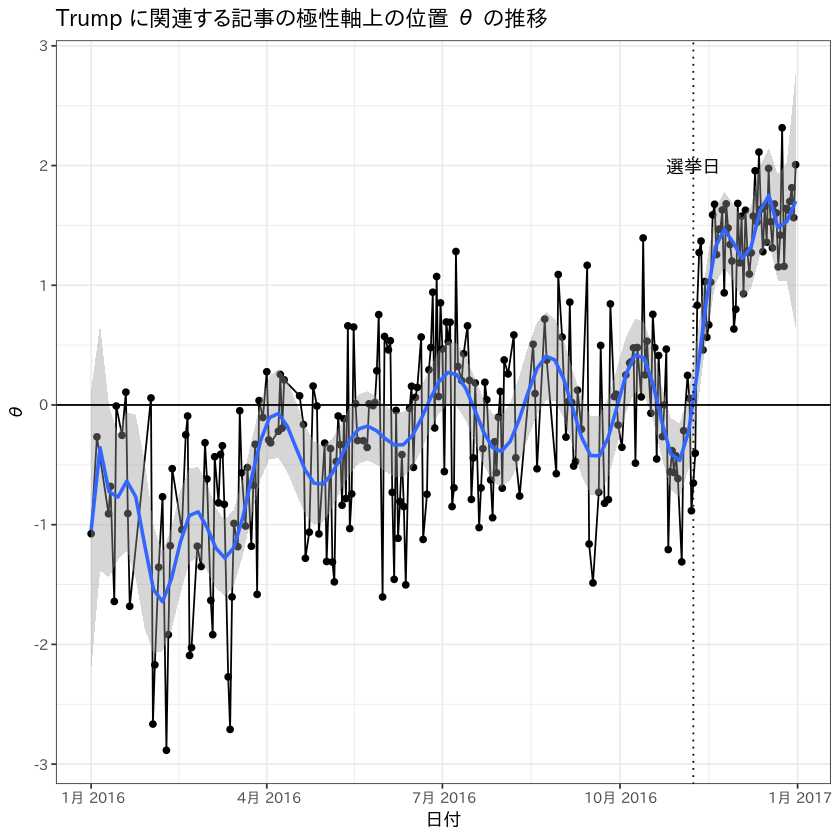

In [12]:
par(family="IPAGothic")
ggplot(data = trump_theta, mapping = aes(x = Date, y = Estimated_theta)) +
  geom_point() +
  geom_line() +
  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = TRUE) +
  geom_abline(intercept = 0, slope = 0) +
  geom_vline(xintercept = as.Date("2016-11-08"), linetype = 3) +
  annotate("text", x = as.Date("2016-11-08"), y = 2, label = "選挙日") +
  labs(title = "Trump に関連する記事の極性軸上の位置 θ の推移",
       x = "日付",
       y = "θ")

##### 単語の極性軸上の推定位置 $\phi$ と $\beta$

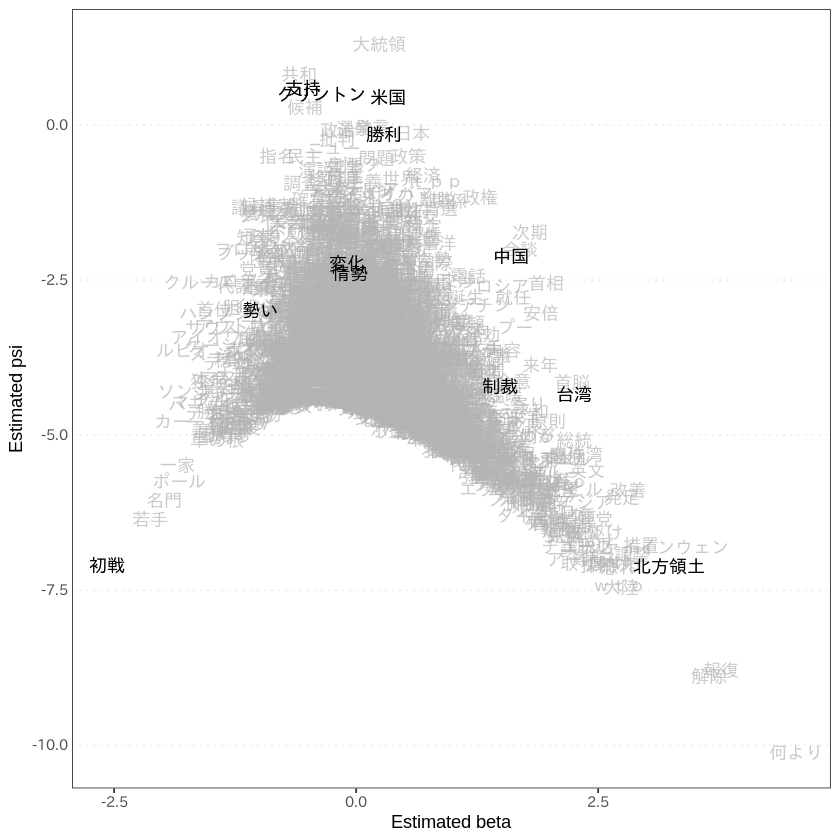

In [13]:
textplot_scale1d(wf_trump, margin = "features", 
                 highlighted = c("クリントン", "情勢", "米国", "勢い", "変化", "支持",
                                 "勝利", "中国", "制裁", "台湾", "北方領土",
                                 "初戦"))

##### $\psi$ 上位単語 (ストップワードや背景語)

In [14]:
print_psi(wf_trump, topn=10, reverse = TRUE)

1.29564454187802 大統領 
0.811835555505852 共和 
0.579579928291255 支持 
0.485063576442333 クリントン 
0.438477210553349 米国 
0.283455573528847 候補 
-0.0424253092487631 発言 
-0.0539048898479413 選挙 
-0.0925536161365787 政治 
-0.136990125164914 日本 


##### $\beta$ 上位単語（正の極性語）

In [15]:
print_beta(wf_trump, topn=10, reverse=TRUE)

4.54728858011344 何より 
3.76509640295153 報復 
3.64769837061281 解除 
3.23301952065567 北方領土 
3.10319732893759 ツァイインウェン 
2.94006060314535 措置 
2.84450013582941 調整 
2.80427076200782 改善 
2.74981625758445 発足 
2.73747264462425 大陸 


##### $\beta$ 下位単語（負の極性語）

In [16]:
print_beta(wf_trump, topn=10)

-2.5785240076927 初戦 
-2.13152724894456 若手 
-1.9847943369424 名門 
-1.89778001872177 カー 
-1.87419615644493 ソン 
-1.84599706414738 一家 
-1.82713199329232 ポール 
-1.78780821993282 ルビオ 
-1.62134381491844 クルーズ 
-1.57478284109061 一本 


##### トランプとクリントンの $\theta$ の推移比較

In [17]:
mx <- corpus_trim(data_corpus_asahi_2016, exclude_pattern = "^(?!.*クリントン).*$") %>% 
  tokens(remove_punct = TRUE) %>% 
  dfm() %>% 
  dfm_remove(pattern = 'クリントン', valuetype = 'fixed') %>%
  dfm_select(min_nchar = 2) %>% 
  dfm_remove('^[ぁ-ん]+$', valuetype = 'regex', min_nchar = 2) %>% 
  dfm_trim(min_docfreq = 3) %>% 
  dfm_subset(date >= '2016-01-01')

mx <- mx %>% 
  dfm_group(factor(docvars(mx, 'date'), levels = as.factor(unique(date))), fill = FALSE)

mx <- mx[order(docnames(mx)),]
mx

result <- mx %>% 
  textmodel_wordfish() %>% 
  summary()

theta = tibble(
  Date = as.Date(names(which(ntoken(mx) > 0))),
  Estimated_theta = result$estimated.document.positions$theta
)

#ggplot(data = theta, mapping = aes(x = Date, y = Estimated_theta)) +
#  geom_point() +
#  geom_line() +
#  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = FALSE)

trump <- trump_theta %>% 
  add_column(Who="Trump")

clinton <- theta %>% 
  add_column(Who="Clinton")

Document-feature matrix of: 199 documents, 929 features (95.83% sparse) and 3 docvars.
            features
docs         民主 ヒラリー 国務 長官 優位 立つ 問題 共和 米国 大統領
  2016-01-04    1        1    1    1    1    1    1    1    0      0
  2016-01-05    1        1    0    0    0    0    0    0    1      1
  2016-01-08    0        1    0    0    0    0    1    0    0      1
  2016-01-10    1        0    1    1    0    0    0    1    0      0
  2016-01-17    0        1    0    0    0    0    0    0    0      2
  2016-01-19    0        1    1    1    1    0    0    1    0      3
[ reached max_ndoc ... 193 more documents, reached max_nfeat ... 919 more features ]

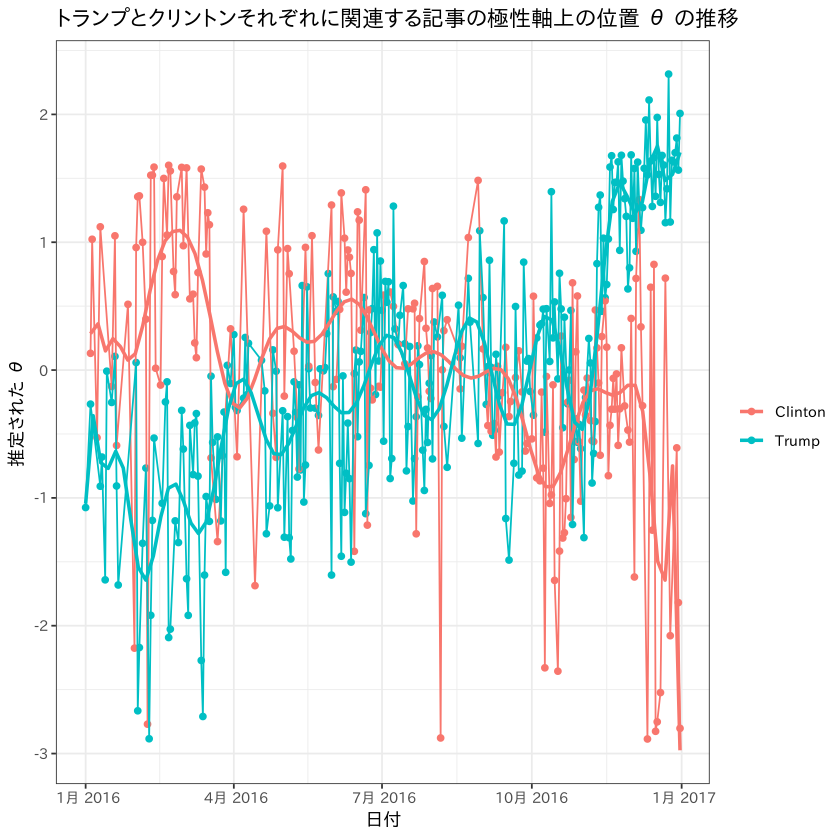

In [18]:
ggplot(data = rbind(trump, clinton),
       mapping = aes(x = Date, y = Estimated_theta, group = Who)) +
  geom_point(mapping = aes(colour = Who)) +
  geom_line(mapping = aes(colour = Who)) +
  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = FALSE, mapping = aes(colour = Who)) +
  labs(title = "トランプとクリントンそれぞれに関連する記事の極性軸上の位置 θ の推移",
       x = "日付",
       y = "推定された θ",
       colour = "")

### LSS による分析例

#### 例3. 2016 年の Guardian ニュースの経済記事
一般的な感情極性語を種語として経済記事の極性（景況感的なモノ？） $\theta$ の時間推移を分析したもの（LSS のチュートリアルほぼそのまま）

In [19]:
corp_gdn <- download("data_corpus_guardian")

In [20]:
sent_gdn <- corpus_reshape(corp_gdn, to =  "sentences")
toks_gdn <- sent_gdn %>% 
  tokens(remove_punct = TRUE, remove_symbols = TRUE, 
         remove_numbers = TRUE, remove_url = TRUE) %>% 
  tokens_remove(stopwords("en", source = "marimo")) %>%
  tokens_remove(c("*-time", "*-timeUpdated", "GMT", "BST", "*.com"))  

mx_gdn <- toks_gdn %>% 
  dfm() %>% 
  dfm_remove(pattern = "") %>% 
  dfm_trim(min_termfreq = 5)

使用した種語（感情極性）

In [21]:
seed <- as.seedwords(data_dictionary_sentiment)
#for (i in 1:length(seed)) {
#  cat(seed[i][[1]], ' ', names(seed)[i][[1]], '\n')
#}
print(seed)

       good        nice   excellent    positive   fortunate     correct 
          1           1           1           1           1           1 
   superior         bad       nasty        poor    negative unfortunate 
          1          -1          -1          -1          -1          -1 
      wrong    inferior 
         -1          -1 


文脈語 "econom*" として特徴語を抽出

In [22]:
#| warning: false

eco_gdn <- char_context(toks_gdn, pattern = "econom*", p = 0.05)
lss_gdn <- textmodel_lss(mx_gdn, seeds = seed,
                          terms = eco_gdn, k = 300, cache = TRUE)

Writing cache file: lss_cache/svds_b0214ddd80fa3ae4.RDS



抽出された正の特徴語

In [23]:
head(coef(lss_gdn), 20) # most positive words

good    positive opportunity      status     success      energy 
 0.13285869  0.10040401  0.09826238  0.09447725  0.08504318  0.07928380 
    quarter       third     rolling       hopes       model    regional 
 0.07085944  0.06552947  0.06508616  0.06428040  0.06278460  0.06159800 
   strategy    maintain      points     welcome        halt     smaller 
 0.06148539  0.06071669  0.06055592  0.06015705  0.05912699  0.05848561 
    reasons      slowed 
 0.05699532  0.05694853

抽出された負の特徴語

In [24]:
tail(coef(lss_gdn), 20) # most negative words

uncertainty       worse      credit       taxes         cut      blamed 
-0.08437856 -0.08745937 -0.08917543 -0.09203618 -0.09205722 -0.09262036 
    reserve      caused     raising      easing         low     cutting 
-0.09337344 -0.09710604 -0.09914218 -0.10106988 -0.10376902 -0.10473368 
      raise      warned    interest      bubble    negative       rates 
-0.10610514 -0.11025466 -0.11985742 -0.12122050 -0.13117556 -0.13236670 
       poor         bad 
-0.13416590 -0.14752822

[data_dictionary_LSD2015](https://www.rdocumentation.org/packages/quanteda/versions/2.0.0/topics/data_dictionary_LSD2015) の極性語とコーパス中の単語のオーバーラップをプロットしたもの

正の極性語

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


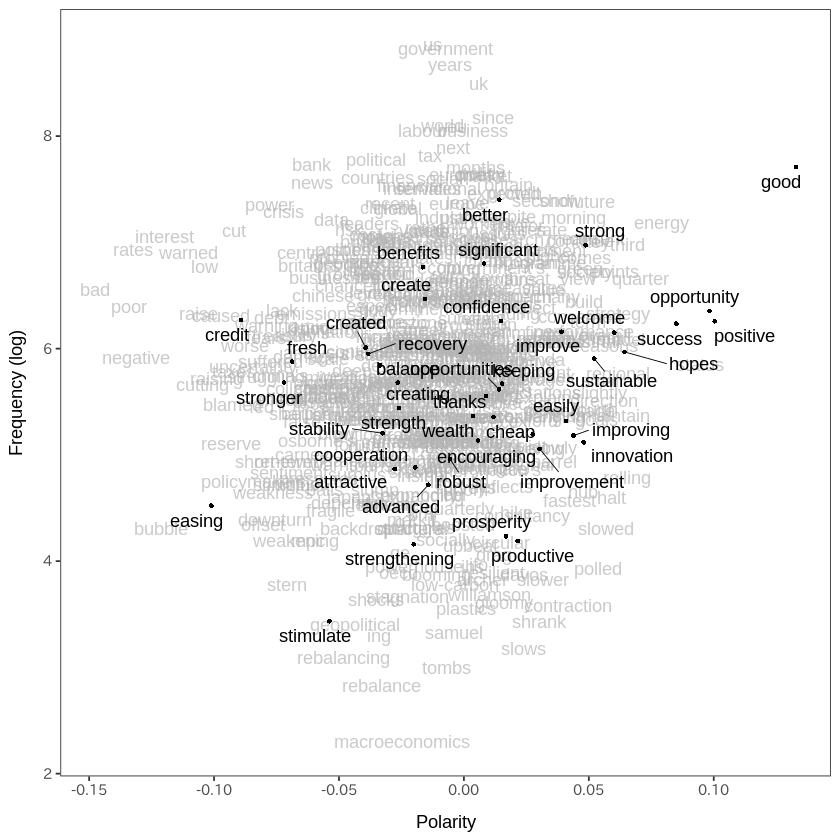

In [25]:
#| warning: false

textplot_terms(lss_gdn, data_dictionary_LSD2015["positive"])

負の極性語

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


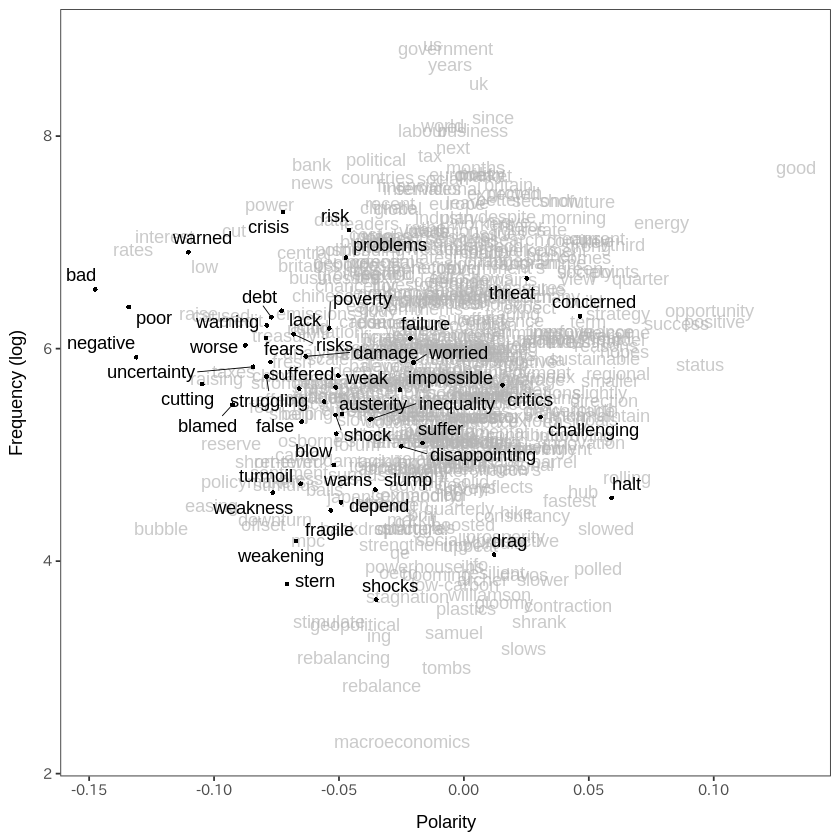

In [26]:
#| warning: false

textplot_terms(lss_gdn, data_dictionary_LSD2015["negative"])

Document-feature matrix of: 6,000 documents, 30,022 features (99.15% sparse) and 9 docvars.
            features
docs         london climate change want understand guardian's assistant
  text136751      2       3      2    1          1          1         1
  text118588      0       0      0    1          0          0         0
  text45146       0       0      2    0          0          0         0
  text93623       0       0      0    0          0          0         0
  text136585      1       0      3    2          0          2         0
  text65682       0       0      0    0          0          0         1
            features
docs         national news editor
  text136751        1    1      1
  text118588        0    0      0
  text45146         0    0      0
  text93623         0    0      0
  text136585        0    0      0
  text65682         0    1      0
[ reached max_ndoc ... 5,994 more documents, reached max_nfeat ... 30,012 more features ]

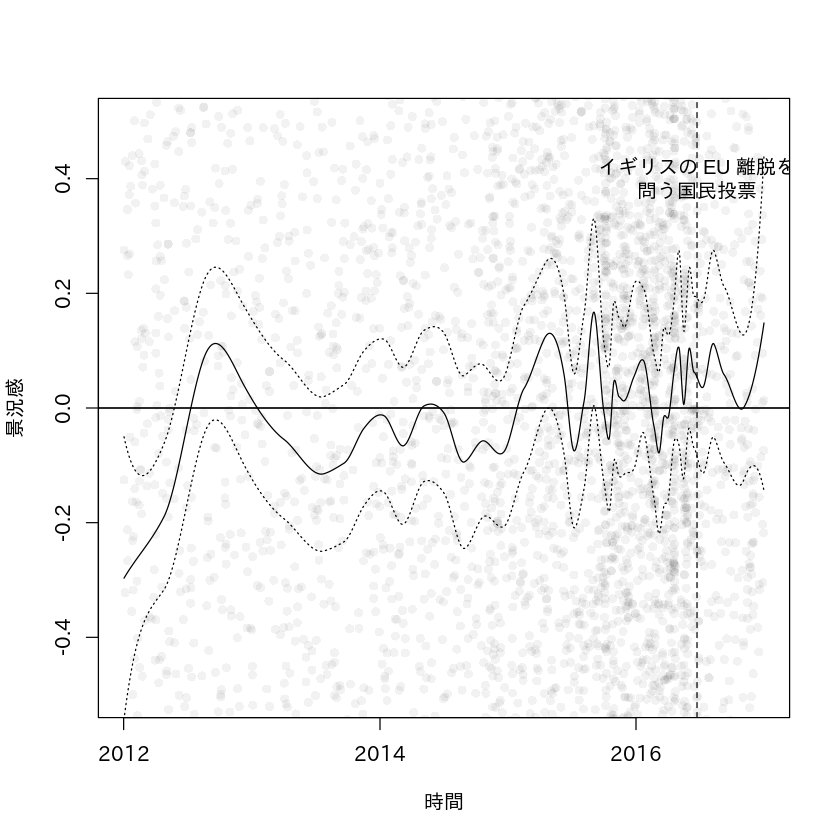

In [27]:
## We reconstruct original articles from their sentences using dfm_group() before predicting polarity of documents.
mx_doc_gdn <- dfm_group(mx_gdn)
mx_doc_gdn
dat_gdn <- docvars(mx_doc_gdn)
dat_gdn$fit <- predict(lss_gdn, newdata = mx_doc_gdn)

## We can smooth polarity scores of documents to visualize the trend using smooth_lss(). If engine = "locfit", smoothing is very fast even when there are many documents.
dat_gdn_smooth <- smooth_lss(dat_gdn, engine = "locfit")

## In the plot below, the circles are polarity scores of documents and the curve is their local means with 95% confidence intervals.
plot(dat_gdn$date, dat_gdn$fit, col = rgb(0, 0, 0, 0.05), pch = 16, ylim = c(-0.5, 0.5),
     xlab = "時間", ylab = "景況感")
lines(dat_gdn_smooth$date, dat_gdn_smooth$fit, type = "l")
lines(dat_gdn_smooth$date, dat_gdn_smooth$fit + dat_gdn_smooth$se.fit * 1.96, type = "l", lty = 3)
lines(dat_gdn_smooth$date, dat_gdn_smooth$fit - dat_gdn_smooth$se.fit * 1.96, type = "l", lty = 3)
abline(h = 0, lty = c(1, 2))
abline(h = 0, v = as.Date("2016-06-23"), lty = c(1, 2))
text(as.Date("2016-06-23"), 0.4, "イギリスの EU 離脱を\n問う国民投票")

### 極性公開データによる評価
Wordfish と LSS が推定する極性値が人間の評価指標とどれだけ相関があるのかみて見る。  
テキストの極性評価データは少ないので、一旦 PLSS の評価でも使用されている [Young and Soroka](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/H2FEPO) (以下 YS) を使って再評価するのみにする。
YS による Wordfish の評価はない。  

YS は、New York Times から採られた900個の記事からなり、半分は1988–2008年の経済面から、残りの半分は2007–2009年の環境・外交・犯罪に関する一面記事からランダムにサンプリングされたものになっている。

実験では、経済面と環境・外交・犯罪それぞれについて、人手評価と相関を測っている。
LSS における目標語は、経済については、"econom*", "compan*", "job*", "consumer*" を指定。環境・外交・犯罪については、"american*", "state*", "united*", "war", "government", "obama" を指定。種語は上の分析例と同じものを使用（この目標語の選択で結果が結構変わる）  

人手評価の計算方法は、PLSS の論文に同じ。

In [28]:
load("../data/YoungSoroka.2012.Rdata")

### 全体
ys <- YS %>% 
  as_tibble() %>% 
  mutate(is_pos_1 = if_else(code_1 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_1 = if_else(code_1 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_2 = if_else(code_2 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_2 = if_else(code_2 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_3 = if_else(code_3 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_3 = if_else(code_3 == 'Negative', TRUE, FALSE)) %>% 
  mutate(n_pos = is_pos_1 + is_pos_2 + is_pos_3) %>% 
  mutate(n_neg = is_neg_1 + is_neg_2 + is_neg_3) %>%
  mutate(scale = if_else(n_pos == 3, 5, if_else(n_pos ==2, 4, if_else(n_neg == 2, 2, if_else(n_neg == 3, 1, 3)))))

#wf <- wordfish(ys, remove_stopwords = TRUE, stem = FALSE, min_docfreq = 10, max_docfreq = 0.8)
#smr <- summary(wf)
#ys <- ys %>% 
#  add_column(theta = smr$estimated.document.positions$theta)
#cor <- cor(ys$scale, ys$theta, method="pearson")
#print(cor)
#ggplot(data = ys, mapping = aes(x = theta, y = scale, group = scale)) +
#  geom_boxplot()

In [29]:
corp_lss_ys <- corpus(ys, text_field = 'body')

toks_lss_ys <- corp_lss_ys %>% 
  corpus_reshape("sentences") %>% 
  tokens(remove_punct = TRUE, remove_symbols = TRUE, 
         remove_numbers = TRUE, remove_url = TRUE) %>% 
  tokens_remove(stopwords("en", source = "marimo")) %>% 
  tokens_remove(c("*-time", "*-timeUpdated", "GMT", "BST", "*.com")) %>% 
  tokens_tolower()

mx_lss_ys <- toks_lss_ys %>% 
  dfm() %>% 
  dfm_remove(pattern = "") %>% 
  dfm_trim(min_termfreq = 5) %>% 
  dfm_trim(min_docfreq = 3)

In [30]:
#| warning: false

ctx_lss_eco <- char_context(toks_lss_ys, c("econom*", "compan*", "job*", "consumer*"), p = 0.05)
lss_eco <- textmodel_lss(mx_lss_ys, as.seedwords(data_dictionary_sentiment),
                     terms = ctx_lss_eco, k = 300, cache = TRUE)

mx_lss_ys <- dfm_group(mx_lss_ys)
pred_lss_eco <- as.data.frame(predict(lss_eco, se_fit = TRUE, newdata = mx_lss_ys))

theta_lss_eco <- pred_lss_eco$fit
theta_lss_eco[is.na(theta_lss_eco)] <- 0

lss_ys_eco <- ys %>% 
  add_column(theta = theta_lss_eco)

lss_ys_eco <- lss_ys_eco %>% 
  filter(topic == 'Economy')
  
cor_lss_eco <- round(cor(lss_ys_eco$scale, lss_ys_eco$theta), digits=3)
  
g_lss_economy <- ggplot(data = lss_ys_eco, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point() +
  labs(title = paste("lss - economy", " (", cor_lss_eco, ")"),
       x = "",
       y = "")

Writing cache file: lss_cache/svds_820eb8e7e80299e1.RDS



In [31]:
#| warning: false

ctx_lss_fore <- char_context(toks_lss_ys, c("american*", "state*", "united*", "war", "government", "obama"), p = 0.05)
lss_fore <- textmodel_lss(mx_lss_ys, as.seedwords(data_dictionary_sentiment),
                     terms = ctx_lss_fore, k = 300, cache = TRUE)

mx_lss_ys <- dfm_group(mx_lss_ys)
pred_lss_fore <- as.data.frame(predict(lss_fore, se_fit = TRUE, newdata = mx_lss_ys))

theta_lss_fore <- pred_lss_fore$fit
theta_lss_fore[is.na(theta_lss_fore)] <- 0

lss_ys_fore <- ys %>% 
  add_column(theta = theta_lss_fore)

lss_ys_fore <- lss_ys_fore %>% 
  filter(topic == 'Foreign')

cor_lss_fore <- round(cor(lss_ys_fore$scale, lss_ys_fore$theta), digits = 3)
  
g_lss_foreign <- ggplot(data = lss_ys_fore, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point() +
  labs(title = paste("lss - foreign", " (", cor_lss_fore, ")"),
       x = "文書極性",
       y = "")

Writing cache file: lss_cache/svds_daf4ffa3969012a5.RDS



In [32]:
ys_economy <- ys %>%
  filter(topic == 'Economy')
wf <- wordfish(ys_economy, remove_stopwords = TRUE, stem = FALSE, min_docfreq = 10, max_docfreq = 0.8)
smr <- summary(wf)
ys_economy <- ys_economy %>% 
  add_column(theta = smr$estimated.document.positions$theta)

ys_foreign <- ys %>%
  filter(topic == 'Foreign')
wf <- wordfish(ys_foreign, remove_stopwords = TRUE, min_docfreq = 3, max_docfreq = 1.0)
smr <- summary(wf)
ys_foreign <- ys_foreign %>% 
  add_column(theta = smr$estimated.document.positions$theta)

cor_economy <- round(cor(ys_economy$scale, ys_economy$theta, method="pearson"), digits = 3)

g_economy <- ggplot(data = ys_economy, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point() +
  labs(title = paste("wordfish - economy", " (", cor_economy, ")"),
       x = "",
       y = "人手評価")

cor_foreign <- round(cor(ys_foreign$scale, ys_foreign$theta, method="pearson"), digits = 3)

g_foreign <- ggplot(data = ys_foreign, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point() +
  labs(title = paste("wordfish - foreign", " (", cor_foreign, ")"),
       x = "文書極性",
       y = "人手評価")

どの手法、トピックもあまり強い相関は見られず、比較的高い相関係数（括弧内）が出ている Wordfish - foreign についても非常にばらつきが大きい。    
ちなみに PLSS の論文では、LSS の相関係数は、0.065 だったとなっているが、トピック別に推定したのか全体で推定したのか、他詳細の記述はない。PLSS での数字も 0.24 だったとされている。

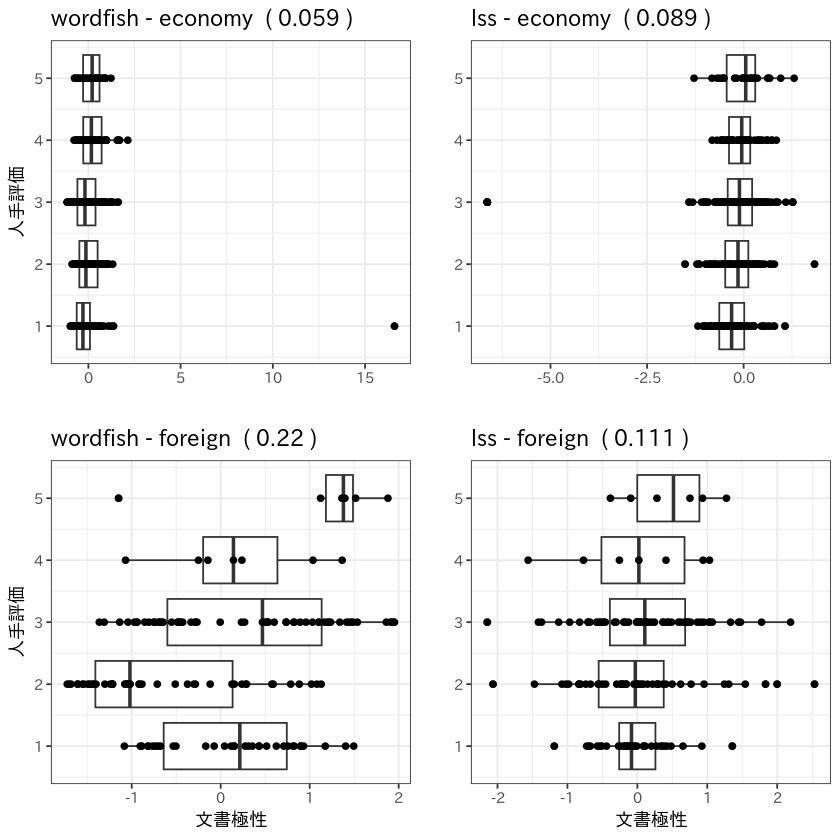

In [33]:
gridExtra::grid.arrange(g_economy, g_lss_economy, g_foreign, g_lss_foreign, ncol = 2)

## 課題
Wordfish は、シンプルな統計的生成モデルで完全に教師なしの分析であることが強みだが、極性軸（尺度の視点）が分析の目的に対応しているかは結果を見て解釈するしかなく、探索的な分析も難しい。  
モデルは単語の頻度を説明するもので、テキスト長さに依存しているという問題もある。  
また、非常にスパースな文書単語行列では、推定が収束しないことが多く(99% 以上が 0 だとほぼ収束しなかった)、収束させるためにヒューリスティックな前処理を必要とし、推定値も安定しなかった。

LSS は、非常にシンプルで直感的な手法で LSS 以前に使われていた LSD (Lexicoder Sentiment Dictionary) のような分析対象固有の極性単語リストを準備するコストを種語を介した特徴語抽出という形で自動化している。  
しかし、種語も一般的な感情極性辞書のような語彙では、より自由な尺度での探索的な分析は難しい気がする。  
論文では、推定された文書の極性にばらつきが多いことやこちらも、ヒューリスティックな前処理の影響が大きいとされている。

## 付録

#### A. 2010年のアイルランドの予算演説における推定された $\theta$ 上位演説の冒頭部分

In [34]:
for (i in order(-smr_irish$estimated.document.positions$theta)) {
  cat(paste('[', names(data_corpus_irishbudget2010)[i], ']',
            'θ =', 
            smr_irish$estimated.document.positions$theta[i],
            '\n',
            str_split(data_corpus_irishbudget2010[i], '\\n\\n')[[1]][1],
            '\n ..... \n\n'))
}

[ Lenihan, Brian (FF) ] θ = 1.79403208978541 
 When I presented the supplementary budget to this House last April, I said we could work our way through this period of severe economic distress. Today, I can report that notwithstanding the difficulties of the past eight months, we are now on the road to economic recovery. 
 ..... 

[ Cowen, Brian (FF) ] θ = 1.77845687266213 
 This country has to address probably the biggest challenge to its economic independence it has ever had to face, even though this is now in the context of our membership of the EU and the Eurozone. The budget will demonstrate to ourselves and to others that we are succeeding in mastering the challenge. It is no time for half-measures, evasion or long-fingering. While others can suggest and propose, or oppose, the Government has the responsibility with the support of the Dáil for taking the measures that the public interest requires at this time. Even in these most difficult financial circumstances, we need to keep m

#### B. 2016年大統領選挙のトランプに関連した朝日新聞記事のうち強い極性 $\theta$ を示した記事（上位/下位それぞれ５記事） 

In [35]:
print_theta(wf_trump, corpus, topn=5, reverse = TRUE)

2.31548740083244 
共和党の大統領候補のトランプ氏（７０）が、政治経験のなさを売りに変革を訴えるのに対し、政治経験が長い実務家のケーン氏の起用で「安定感」を強調する選択となった。  トランプ氏を「不安定で、大統領をまかせられない」と批判しているだけに、安定感を重視したとみられる。  トランプ陣営は、ケーン氏が知事時代に受け取っていた献金を問題視。 

2.11261013104541 
秋の大統領選で共和党の候補者指名を確実にしているトランプ氏はフェイスブックで「何人の警察官と人々が指導力の欠如によって死亡しなければならないのか」と発信した。（ 

2.00749714892601 
クリントン氏支持者がトランプ氏打倒のために党内団結の必要性を説く一方、サンダース氏支持派はなお結果に納得できない。  共和党のトランプ氏は何度もビジネスで破産している。  かといって、イスラム教徒の私は絶対にトランプ氏を支持しない。  トランプ氏阻止にはサンダース氏が最適だと思うし、そのためにこの大会に来た。  ■トランプ氏当選阻止へ団結　ラボン・ブレイシーさん（６７）＝元教会事務員（フロリダ州）　大学院の修了後から子どものために働き続けてきたクリントン氏を信じている。  相手は人種差別的なトランプ氏。 

1.97620276317204 
米共和党の大統領候補に指名されたトランプ氏（７０）は２１日夜（日本時間２２日昼）、オハイオ州で開かれた党全国大会で指名受諾演説を行った。  大会最終日の２１日、党から大統領候補に指名されたトランプ氏が登壇し、指名受諾を宣言。 

1.95632122021636 
米大統領選をめぐり、オハイオ州で開かれている共和党全国大会は１９日夜（日本時間２０日午前）、実業家のドナルド・トランプ氏（７０）を党大統領候補に正式に指名した。  獲得代議員数を集計した結果、トランプ氏が指名獲得に必要な１２３７人を大幅に上回る１７２５人の代議員を獲得して、党の大統領候補指名を獲得。  結果を受け、トランプ氏は「共和党候補となったのは大変光栄だ。  トランプ氏は、大会最終日の２１日に演説し、内政・外交・経済などについての同氏の方針を説明する。  反トランプ派は、党大会で指名候補選出方法を変更して指名を阻止しようとしたが、トランプ支持派に押し切られ、失敗に

In [36]:
print_theta(wf_trump, corpus, topn=5)

-2.88438349540081 
全米規模で支持率首位の民主党・クリントン前国務長官と共和党・トランプ氏だが、初戦となる同州では共に党内のライバル候補と激しく競り合い、予断を許さない情勢だ。  一方、８年ぶりの政権奪還を目指す共和党は、党の主流派に対して「アウトサイダー」と呼ばれる不動産王のトランプ氏と、保守強硬派のクルーズ上院議員が支持率上位を占める。  トランプ氏は不法移民排斥やイスラム教徒の一時入国禁止などを唱え、首位を独走。  初戦のアイオワ州党員集会では、デモイン・レジスターの世論調査でクルーズ氏がトランプ氏に５ポイント差まで迫る勢いを見せ、クルーズ氏は「トランプ氏がアイオワで勝利すれば、勢いが止められなくなる」と阻止を狙う。 

-2.71024242584176 
政治経験がない実業家トランプ氏が各層に支持を浸透させ、サウスカロライナ州予備選挙でも勝利し、本命候補として着々と基盤を固める。  ▼１面参照　■リベラル主張織り交ぜる　共和・トランプ氏　「今夜は素晴らしい夜だ。  ２０日夜、支持者から歓声が沸き上がるのを満足そうに見渡しながら、トランプ氏は笑顔で語った。  メキシコからの不法移民対策やイスラム教徒の入国禁止発言で物議をかもしながらも、国民の間にくすぶる社会への不満や不安を原動力に、支持を得てきたトランプ氏。  宗教、人種、世代、所得など、あらゆる層でまんべんなく支持を拡大しており、ＣＮＮによる投票者への出口調査では、「非常に保守」と答えた人の間ではクルーズ氏がトップだったが、「比較的保守」「穏健」の間ではトランプ氏が圧倒的に支持されている。  投票前日も「私は金持ちからも貧困層からも、背が高くても低くても、どんな人からも最も支持されている」とおどけてみせたトランプ氏。  ■ブッシュ氏撤退、ルビオ氏着々　トランプ氏の大勝と共に、選挙戦の地殻変動を象徴するのが、ブッシュ元フロリダ州知事の撤退表明だ。  伸び悩んだブッシュ氏ら主流派と、トランプ氏ら「アウトサイダー」の中間に位置し、撤退候補の票の受け皿になるとみられているのが、２位につけたルビオ上院議員だ。  トランプ氏が大勝したとはいえ、その得票率は３割強。  今後の予備選・党員集会で候補者の淘汰（とうた）が進み、自分が受け皿になれば、トランプ氏にも対抗できる。  （ラスベガス＝宮地ゆう、コロ